In [3]:
!pip install pytorch-lightning==1.2.2


  Using cached pytorch_lightning-1.2.2-py3-none-any.whl.metadata (25 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached aiohttp-3.11.18-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached grpcio-1.71.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached markdown-3.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.6.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
 

In [4]:
# load packages

import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import TensorDataset, DataLoader

In [5]:
# Unzip data folder
zip_path = "problem2.zip" 
extract_path = "problem2" 
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
#create the training and validation datasets
training_data = np.load( './problem2/problem2/training_data.npz' )
training_images = torch.from_numpy(training_data['a']).float()
training_labels = torch.from_numpy(training_data['b']).long()
train_dataset = TensorDataset(training_images, training_labels)

evaluation_data = np.load( './problem2/problem2/evaluation_data.npz' )
evaluation_images = torch.from_numpy(evaluation_data['a']).float()
evaluation_labels = torch.from_numpy(evaluation_data['b']).long()
val_dataset = TensorDataset(evaluation_images, evaluation_labels)

In [7]:
#define device to use parallelization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#divide the data in batches using DataLoader

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False
)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")

Number of training batches: 375
Number of validation batches: 600


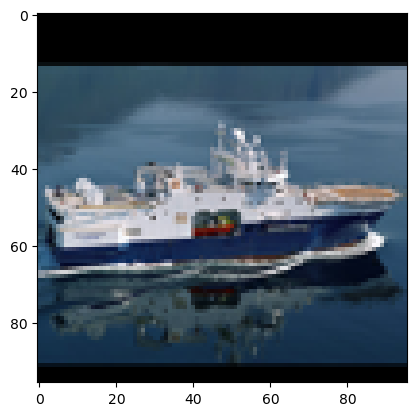

In [9]:
# check one of the images
img = training_data['a'][1]
img_correct = np.transpose(img, (1, 2, 0))
plt.imshow(img_correct)
plt.show()

In [10]:
#define the model

class VGG11(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        """
        # Assumes input images are of size (3, 96, 96).
        """
        super().__init__()
        ## Define the layers
        self.layer1 = nn.Sequential(
            #Eight convolutional layers 
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        #three fully connected layers
        self.layer9 = nn.Sequential(
            nn.Linear(3*3*512, 4096),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.layer11 = nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        ## Define the forward pass
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        #reshape the data to pass it to the fully connected layers
        x = x.reshape(x.size(0), -1)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        return x

#initialize model
model = VGG11(in_channels=3, num_classes=3)

print(f"Using device: {device}")

## Move model to device
model = model.to(device)
print(model)

Using device: cuda
VGG11(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [11]:
def accuracy(soft_pred, target):
    """The number of correct predictions divided by the number of total predictions."""
    return (soft_pred.argmax(dim=1) == target).float().mean()

In [12]:
def confusion_matrix(soft_pred, target):
    """Compute the confusion matrix. Rows represent the true class, columns represent the predicted class.
    This can be useful for understanding which classes are being confused."""
    num_samples = soft_pred.shape[0]
    num_classes = soft_pred.shape[1]
    confusion_matrix = torch.zeros(num_classes, num_classes)
    predicted = soft_pred.argmax(1)
    for i in range(num_samples):
        confusion_matrix[target[i], predicted[i]] += 1
    return confusion_matrix

In [13]:
def evaluate(model, dataloader):
    ## Set model to evaluation mode (important for dropout and batch normalization layers)
    model.eval()
    loss_track = 0
    acc_track = 0

    ## Initialize confusion matrix
    con_mat_track = torch.zeros(3, 3)

    with torch.inference_mode(): 
        for inputs, labels in dataloader:
            ## Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            ## Forward pass
            outputs = model(inputs)

            ## Compute loss
            loss = loss_function(outputs, labels)

            ## Compute metrics
            acc = accuracy(outputs, labels)
            con_mat = confusion_matrix(outputs, labels)

            ## Update statistics
            loss_track += loss.item()
            acc_track += acc
            con_mat_track += con_mat

        ## Compute average loss and accuracy
        loss_track /= len(dataloader)
        acc_track /= len(dataloader)
    return loss_track, acc_track, con_mat_track

In [14]:
def plot_confusion_matrix(cm, path = None):
    """Plots the confusion matrix and saves the plot"""
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(cm, cmap="Blues")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(i, j, f"{cm[j, i]:.0f}", ha="center", va="center")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.xticks(range(3))
    plt.yticks(range(3))
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

In [15]:
#Use cross entropy as loss
loss_function = nn.CrossEntropyLoss()

In [16]:
#use SGD as optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
#define the function to do the training

def train_one_step(model, inputs, labels, loss_function, optimizer):
    inputs = inputs.to(device)
    labels = labels.to(device)

    ## Zero the gradients from last gradient update (otherwise they accumulate)
    optimizer.zero_grad()

    ## Forward pass
    outputs = model(inputs)

    ## Compute loss
    batch_loss = loss_function(outputs, labels)

    ## Backward pass
    batch_loss.backward()
    optimizer.step()

    ## Compute metrics
    batch_acc = accuracy(outputs, labels)
    return batch_loss, batch_acc


def train_one_epoch(model, dataloader):
    ## Set model in training mode
    model.train()

    loss = 0
    acc = 0

    for inputs, labels in dataloader:
        batch_loss, batch_acc = train_one_step(
            model, inputs, labels, loss_function, optimizer
        )
        ## Update statistics
        loss += batch_loss.item()
        acc += batch_acc

    ## Compute average loss and accuracy
    loss /= len(dataloader)
    acc /= len(dataloader)
    return loss, acc

In [48]:
report_template = "Epoch {}: Train loss = {:.4f}, Train acc = {:.4f} | Val loss = {:.4f}, val acc = {:.4f}"
early_stop_patience = 10
best_val_loss = float('inf')
patience_counter = 0

#train the model on the dataset
for epoch in range(1, 100):
    train_loss, train_acc = train_one_epoch(model, train_dataloader)
    val_loss, val_acc, con_mat = evaluate(model, val_dataloader)

    #early stopping criteria
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        #save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break
        
    print(report_template.format(epoch, train_loss, train_acc, val_loss, val_acc))

Epoch 1: Train loss = 0.8039, Train acc = 0.6527 | Val loss = 0.5996, val acc = 0.7500
Epoch 2: Train loss = 0.5705, Train acc = 0.7667 | Val loss = 0.5400, val acc = 0.7783
Epoch 3: Train loss = 0.4784, Train acc = 0.8133 | Val loss = 0.4973, val acc = 0.8100
Epoch 4: Train loss = 0.3739, Train acc = 0.8573 | Val loss = 0.5914, val acc = 0.7567
Epoch 5: Train loss = 0.3066, Train acc = 0.8853 | Val loss = 0.4478, val acc = 0.8238
Epoch 6: Train loss = 0.1972, Train acc = 0.9273 | Val loss = 0.4431, val acc = 0.8458
Epoch 7: Train loss = 0.1904, Train acc = 0.9300 | Val loss = 0.5047, val acc = 0.8263
Epoch 8: Train loss = 0.1031, Train acc = 0.9607 | Val loss = 0.5132, val acc = 0.8379
Epoch 9: Train loss = 0.1294, Train acc = 0.9527 | Val loss = 0.6279, val acc = 0.8175
Epoch 10: Train loss = 0.0773, Train acc = 0.9727 | Val loss = 0.6159, val acc = 0.8367
Epoch 11: Train loss = 0.0882, Train acc = 0.9667 | Val loss = 0.5998, val acc = 0.8454
Epoch 12: Train loss = 0.0519, Train acc 

In [49]:
#load the best model found
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

<All keys matched successfully>

After training: Val loss = 0.4431, Val accuracy = 0.8458
Confusion matrix:


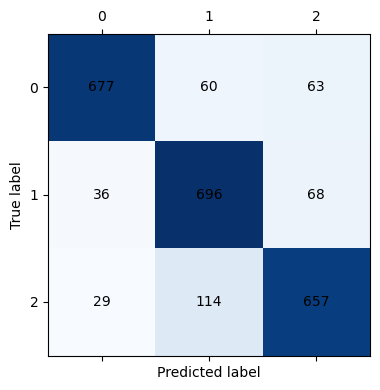

In [50]:
## Evaluate the model on the validation set
val_loss, val_acc, con_mat = evaluate(model.to(device), val_dataloader)
print(f"After training: Val loss = {val_loss:.4f}, Val accuracy = {val_acc:.4f}")
print("Confusion matrix:")
plot_confusion_matrix(con_mat, "./conf_mat_val.png")

In [18]:

model = VGG11(in_channels=3, num_classes=3)

print(f"Using device: {device}")

#add dropout to layer 9 and layer 10

model.layer9 = nn.Sequential(
    nn.Linear(3*3*512, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)
model.layer10 = nn.Sequential(
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)

## Move model to device
model = model.to(device)
print(model)


Using device: cuda
VGG11(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [19]:
#redefine optimizer and loss_function

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [44]:
#repeat training as before

report_template = "Epoch {}: Train loss = {:.4f}, Train acc = {:.4f} | Val loss = {:.4f}, val acc = {:.4f}"
early_stop_patience = 10
best_val_loss = float('inf')
patience_counter = 0


for epoch in range(1, 100):
    train_loss, train_acc = train_one_epoch(model, train_dataloader)
    val_loss, val_acc, con_mat = evaluate(model, val_dataloader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break
        
    print(report_template.format(epoch, train_loss, train_acc, val_loss, val_acc))

Epoch 1: Train loss = 0.0853, Train acc = 0.9680 | Val loss = 0.6079, val acc = 0.8300
Epoch 2: Train loss = 0.1138, Train acc = 0.9607 | Val loss = 0.6740, val acc = 0.8321
Epoch 3: Train loss = 0.0895, Train acc = 0.9700 | Val loss = 0.5607, val acc = 0.8400
Epoch 4: Train loss = 0.0652, Train acc = 0.9807 | Val loss = 0.4733, val acc = 0.8592
Epoch 5: Train loss = 0.0713, Train acc = 0.9793 | Val loss = 0.5222, val acc = 0.8396
Epoch 6: Train loss = 0.0544, Train acc = 0.9813 | Val loss = 0.5249, val acc = 0.8633
Epoch 7: Train loss = 0.0441, Train acc = 0.9880 | Val loss = 0.7117, val acc = 0.8442
Epoch 8: Train loss = 0.0957, Train acc = 0.9640 | Val loss = 0.4839, val acc = 0.8688
Epoch 9: Train loss = 0.0150, Train acc = 0.9973 | Val loss = 0.5508, val acc = 0.8692
Epoch 10: Train loss = 0.0026, Train acc = 0.9993 | Val loss = 0.5903, val acc = 0.8742
Epoch 11: Train loss = 0.0009, Train acc = 1.0000 | Val loss = 0.6287, val acc = 0.8771
Epoch 12: Train loss = 0.0006, Train acc 

In [47]:
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

<All keys matched successfully>

After training: Val loss = 0.4733, Val accuracy = 0.8592
Confusion matrix:


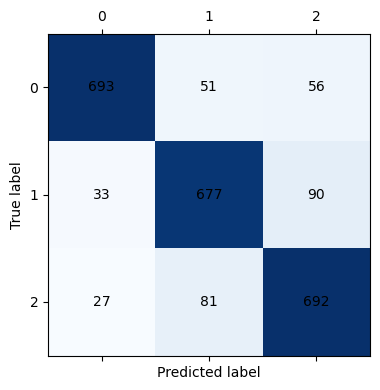

In [48]:
## Evaluate the model on the validation set
val_loss, val_acc, con_mat = evaluate(model.to(device), val_dataloader)
print(f"After training: Val loss = {val_loss:.4f}, Val accuracy = {val_acc:.4f}")
print("Confusion matrix:")
plot_confusion_matrix(con_mat,  "./conf_mat_val_drop.png")

In [49]:
#load new data, create the dataset and the dataloader

new_evaluation_data = np.load('./problem2/problem2/new_evaluation_data_with_labels.npz')
new_evaluation_images = new_evaluation_data['a'] 
new_evaluation_labels = new_evaluation_data[ 'b' ]
unlabeled_evaluation_data = np.load('./problem2/problem2/new_evaluation_data_without_labels.npz' )
unlabeled_evaluation_images = unlabeled_evaluation_data['a'] # no ’ b ’

dim_dataset = np.shape(new_evaluation_images)[0]

index = torch.arange(dim_dataset)

entropy_dataset = TensorDataset(torch.from_numpy(new_evaluation_images).float(), torch.from_numpy(new_evaluation_labels).long(), index)

batch_size = 4
entropy_dataloader = torch.utils.data.DataLoader(
    dataset=entropy_dataset, batch_size=batch_size, shuffle=False
)

print(f"Dimension of the dataset: {dim_dataset}, Number of training batches: {len(entropy_dataloader)}")


Dimension of the dataset: 1600, Number of training batches: 400


In [50]:
def find_entropy(model, dataloader, dim_dataset):
    """This function computes entropy for a set om images"""
    model.eval()
    #initialize return vector
    entropy_sample = torch.zeros(dim_dataset, dtype=torch.float32).to(device)

    with torch.inference_mode():  ## also works with torch.no_grad(), but torch.inference_mode() is more explicit, future-proof and preferred
        for batch in dataloader:
            #check if labels are present
            if len(batch) == 3:
                inputs, labels, index = batch
            elif len(batch) == 2:
                inputs, index = batch
                labels = None
            else:
                raise ValueError("Unexpected batch format: should have 2 or 3 elements per batch")


            ## Move data to device
            inputs = inputs.to(device)
            index = index.to(device)
            #repeat 10 times for each image

            softmax_outputs_sum = torch.zeros_like(model(inputs))
            for cont in range(10):
                ## Forward pass
                outputs = model(inputs)
                
                #compute softmax
                outputs = outputs.exp()
                softmax_outputs_sum += outputs / outputs.sum(1, keepdim=True)
                #outputs = torch.argmax(outputs / outputs.sum(1, keepdim=True), dim=1)


            mean_softmax_outputs = softmax_outputs_sum / 10

            
            
            entropy_sample[index] = -(mean_softmax_outputs * mean_softmax_outputs.log()).sum(dim=1)




    return entropy_sample

In [51]:
entropy = find_entropy(model, entropy_dataloader, dim_dataset).detach().cpu().numpy()
entropy

array([3.7714916e-01, 3.4290159e-01, 2.9559276e-05, ..., 1.2485583e-06,
       3.0224007e-03, 1.0963972e-01], dtype=float32)

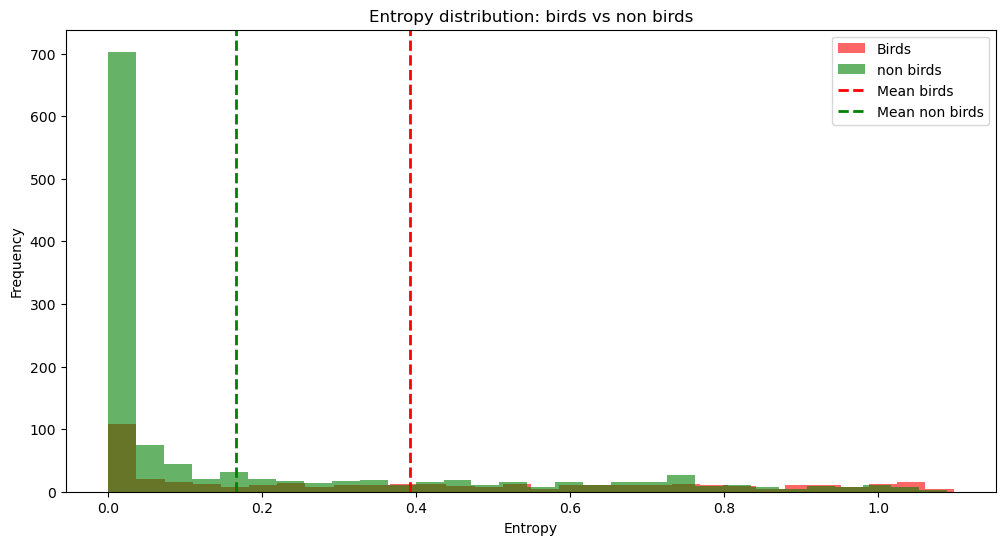

In [52]:
# Data masks
birds = (entropy[new_evaluation_labels == 3])
not_birds = (entropy[new_evaluation_labels != 3])

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(birds, bins=30, alpha=0.6, label='Birds', color='red')
plt.hist(not_birds, bins=30, alpha=0.6, label='non birds', color='green')

# Plot mean lines
plt.axvline(birds.mean(), color='red', linestyle='--', linewidth=2, label='Mean birds')
plt.axvline(not_birds.mean(), color='green', linestyle='--', linewidth=2, label='Mean non birds')

# Labels and title
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.title("Entropy distribution: birds vs non birds")
plt.legend()
plt.savefig("./hist_birds.png")
plt.show()


In [53]:
np.size(birds), np.size(not_birds)

(413, 1187)

In [54]:
x = entropy
x

array([3.7714916e-01, 3.4290159e-01, 2.9559276e-05, ..., 1.2485583e-06,
       3.0224007e-03, 1.0963972e-01], dtype=float32)

In [55]:
def loss_bird(x, birds, not_birds, len_bird, len_not_bird):
    
    #we want to maximize the sum of the ratio of bird pictures eliminated and non bird pictures kept
    return np.argmax( np.sum(birds>=x[:, None], axis=1)/len_bird +  np.sum(not_birds<x[:, None], axis=1)/len_not_bird)

In [56]:
threshold_index = loss_bird(x, birds, not_birds, np.size(birds), np.size(not_birds))
#find the threshold
threshold = x[threshold_index]
threshold

0.10521319

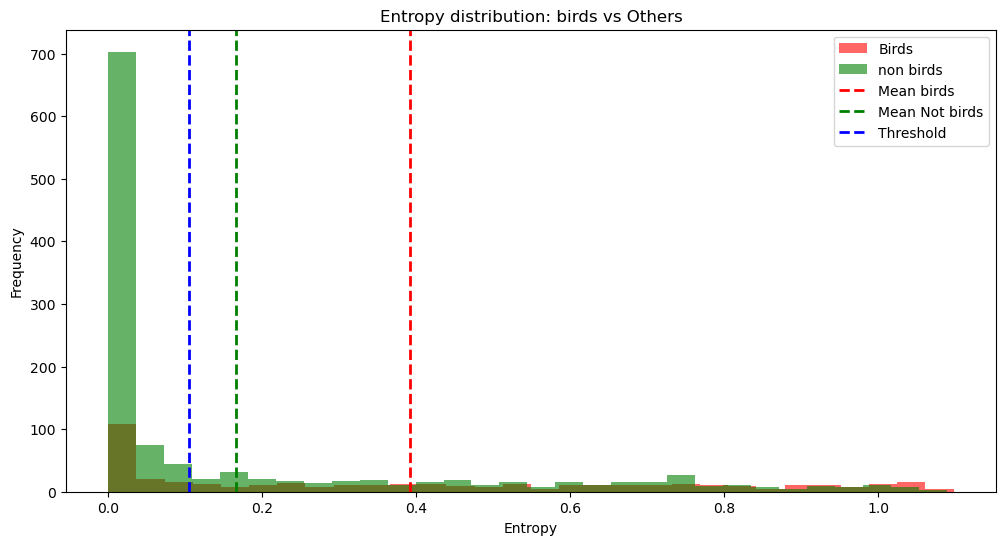

In [57]:
# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(birds, bins=30, alpha=0.6, label='Birds', color='red')
plt.hist(not_birds, bins=30, alpha=0.6, label='non birds', color='green')

# Plot mean lines
plt.axvline(birds.mean(), color='red', linestyle='--', linewidth=2, label='Mean birds')
plt.axvline(not_birds.mean(), color='green', linestyle='--', linewidth=2, label='Mean Not birds')
plt.axvline(threshold, color='blue', linestyle='--', linewidth=2, label='Threshold')

# Labels and title
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.title("Entropy distribution: birds vs Others")
plt.legend()
plt.savefig("./hist_thres.png")
plt.show()

In [58]:
print(np.sum(birds>=threshold) , np.sum(not_birds > threshold))

273 368


In [59]:
#load unlabelled dataset

unlabeled_evaluation_images = unlabeled_evaluation_data['a'] # no ’ b ’

dim_dataset = np.shape(unlabeled_evaluation_images)[0]

index = torch.arange(dim_dataset)

unlab_eval_dataset = TensorDataset(torch.from_numpy(unlabeled_evaluation_images).float(), index)

batch_size = 4
unlab_eval_dataloader = torch.utils.data.DataLoader(
    dataset=unlab_eval_dataset, batch_size=batch_size, shuffle=False
)

print(f"Number of training batches: {len(unlab_eval_dataloader)}")

Number of training batches: 400


In [60]:
#find entropy for the unlabelled dataset

entropy_unlab = find_entropy(model, unlab_eval_dataloader, dim_dataset).detach().cpu().numpy()

In [61]:
#keep the images under the threshold

below_tresh = entropy_unlab < threshold
print(f"Number of predicted known classes samples: {np.sum(below_tresh)}")

Number of predicted known classes samples: 937


In [62]:
#save the prediction
np.savez('./prediction_classes.npz',below_tresh)